In [1]:
import torch 
import math
import numpy as np
import pandas as pd
import skimage 
import src
import src.datasets
import os
import scipy
import sklearn
import seaborn as sns
import json

from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from torchvision import transforms
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
from sklearn.metrics import balanced_accuracy_score

from src.evaluation import load_iccns
from src.utils import set_random_seeds
from hydra import initialize, compose
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn
from torch.nn import functional as F
from skimage.segmentation import mark_boundaries
from lime import lime_image
from sklearn import svm, tree
from aif360.sklearn.metrics import equal_opportunity_difference
from sklearn.neural_network import MLPClassifier

In [2]:
%matplotlib inline

In [3]:
set_random_seeds(65)

# Evaluation of Experiments 
In this notebook we set up the evaluation of our experiments. We also implement the visualisation. 

# Experiment 1
## CelebA
### Quadratic Wasserstein distance

In [4]:
# paths 
attributes = ["Wearing_Necktie", "Eyeglasses", "Wearing_Hat", "Smiling"]

celebA_csv = "../data/celeba/list_attr_celeba.csv"
uniform_csv = "../data/celeba/experiment1_uniform_sample.csv"
biased_csvs = dict()
dataframes = dict()
for attr in attributes:
    biased_csvs[attr] = ["../data/celeba/experiment1_biased_sample_{}_{}.csv".format(attr, n) for n in [10,30,60,90]]
    dataframes[attr] = [pd.read_csv(biased_csvs[attr][i]) for i in range(4)]

In [5]:
df = pd.read_csv(uniform_csv)

print("Percentage of attributes in the original CelebA dataset:\n")
for attr in attributes:
    print(attr, 100*len(df[df[attr]==1])/len(df))

Percentage of attributes in the original CelebA dataset:

Wearing_Necktie 7.2
Eyeglasses 6.7444444444444445
Wearing_Hat 4.477777777777778
Smiling 47.355555555555554


In [6]:
# read datatframe of the uniform sample
unif_df = pd.read_csv(uniform_csv)

In [7]:
# read results of the computation of Wasserstein distance stored in a .tsv
wasserstein_df = pd.read_csv("../results/experiment1/wasserstein.tsv", sep= "\t", header=None)
wasserstein_df.columns = ["X", "Y", "features", "wasserstein"]

wasserstein_df.head()

,X,Y,features,wasserstein
0,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,2.894086
1,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,7.785245
2,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,18.817941
3,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,34.127332
4,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,34.127332


In [8]:
def extract_attribute(file, attributes):
    """
    Utility function to extract the attributes 
    from a file name. 
    """
    for attr in attributes:
        if attr in file:
            return attr

# extract the attribute name from the file name stored in the column "X"
wasserstein_df["attr"] = wasserstein_df["X"].apply(lambda x: extract_attribute(x, attributes))
wasserstein_df.drop_duplicates(inplace=True)

wasserstein_df.head()

,X,Y,features,wasserstein,attr
0,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,2.894086,Wearing_Hat
1,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,7.785245,Wearing_Hat
2,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,18.817941,Wearing_Hat
3,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,34.127332,Wearing_Hat
5,../data/celeba/experiment1_biased_sample_Weari...,../data/celeba/experiment1_uniform_sample.csv,resnet18,2.647499,Wearing_Necktie


In [9]:
wasserstein = {attr: list(wasserstein_df[wasserstein_df["attr"] == attr].wasserstein)\
               for attr in attributes}

print("Results of the computation of the Wasserstein distance:\n")
wasserstein

Results of the computation of the Wasserstein distance:



{'Wearing_Necktie': [2.647498583475752,
  5.45314091406928,
  15.562698566012912,
  30.20531369103325],
 'Eyeglasses': [2.56419087897406,
  4.859932377285425,
  11.24941182115343,
  19.60691512637668],
 'Wearing_Hat': [2.8940860341390007,
  7.7852453672621,
  18.81794062889947,
  34.12733239661323],
 'Smiling': [3.415769812689888,
  2.9724747755262517,
  2.6111294665866467,
  3.211715970357254]}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


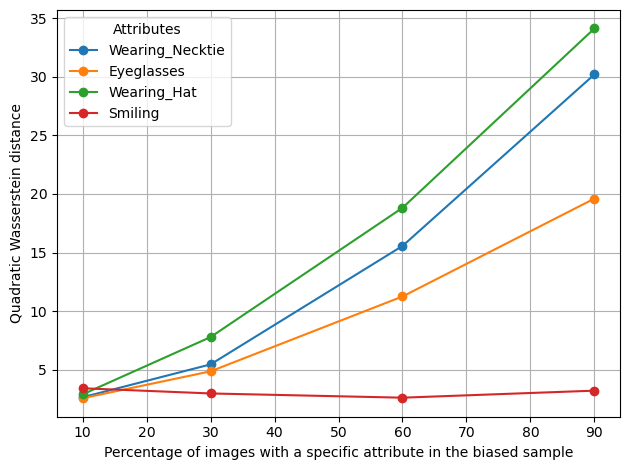

In [10]:
# plot of the results 
for i, item in enumerate(wasserstein.items()):

    attr, scores = item
    c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o", c=c)

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Quadratic Wasserstein distance")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/Wasserstein_distance_plot_2.eps", format="eps")
plt.show()

### SVM-based baseline

In [11]:
distances = dict()
decision_functions = dict()
accuracy = dict()

# load embedded vectors for the uniform space
space_unif = [torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach().numpy()\
         for file in unif_df["image_id"]]

for attr in attributes:
    distances[attr] = dict()
    decision_functions[attr] = dict()
    accuracy[attr] = dict()
    
    for j in range(4):
        n = [10,30,60,90][j]
        
        dataframes[attr][j]["biased"] = 1
        unif_df["biased"] = -1
        
        space = [torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach().numpy()\
                 for file in dataframes[attr][j]["image_id"]] + space_unif
        
        concat = pd.concat([dataframes[attr][j], unif_df])
        y = concat["biased"]

        X = np.concatenate(space)
        y = np.array(y)
        
        # define the classifier
        classifier = svm.SVC(C=.01, kernel="linear", decision_function_shape="ovo")
        
        # train the classifier
        classifier.fit(X, y)
        distances[attr][n] = (.5*(classifier.decision_function(X)/np.linalg.norm(classifier.coef_))**2).mean()
        accuracy[attr][n] = classifier.score(X, y)
        
        df = concat[concat["biased"] == 1].copy()
        df["Distance"] = classifier.decision_function(X[y == 1])/np.linalg.norm(classifier.coef_)
        decision_functions[attr][n] = df

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


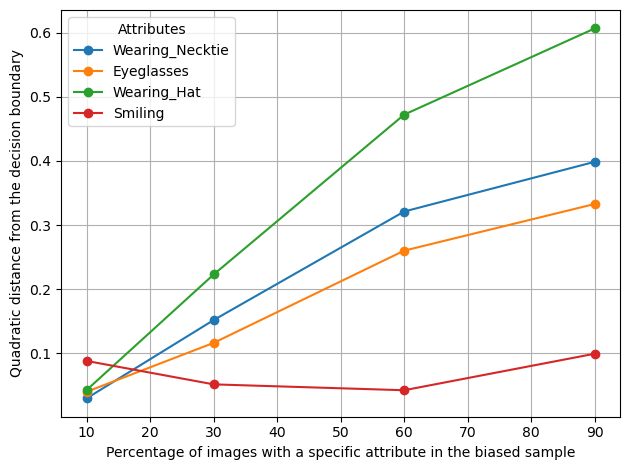

In [12]:
# plot the results
for  i, item in enumerate(distances.items()):
    
    attr, score_dict = item

    scores = [s for n, s in score_dict.items()]
    c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o", c=c)

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Quadratic distance from the decision boundary")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/Distances_plot_2.eps", format ="eps")
plt.show()

### Global bias (Kwegyir-Aggrey et al.)

In [13]:
global_bias = dict()
individual_bias = dict()

space_unif = [torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach().numpy()\
         for file in unif_df["image_id"]]

for attr in attributes:
    global_bias[attr] = dict()
    individual_bias[attr] = dict()
    
    for j in range(4):
        n = [10,30,60,90][j]
        
        space_biased = [torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach().numpy()\
                 for file in dataframes[attr][j]["image_id"]] 
        
        individual_bias_kwegyir = list()
        for s in space_biased:
            distances = list()
            for t in space_unif:
                distances.append(.5*np.linalg.norm(s - t)**2)
            individual_bias_kwegyir.append(np.array(distances).mean())
        global_bias_kwegyir = np.array(individual_bias_kwegyir).mean()
        
        individual_bias[attr][n] = individual_bias_kwegyir
        global_bias[attr][n] = global_bias_kwegyir

In [14]:
global_bias

{'Wearing_Necktie': {10: 124.37386188518579,
  30: 126.59474291705594,
  60: 128.79245528631648,
  90: 131.62947262074155},
 'Eyeglasses': {10: 124.77475418112672,
  30: 129.0812643445065,
  60: 136.11319252807795,
  90: 142.35158116305234},
 'Wearing_Hat': {10: 126.54373957084096,
  30: 135.4910102929327,
  60: 149.10084533597055,
  90: 162.14277212485587},
 'Smiling': {10: 130.32275814992497,
  30: 126.80691308489335,
  60: 122.38141211018996,
  90: 118.1558595929715}}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


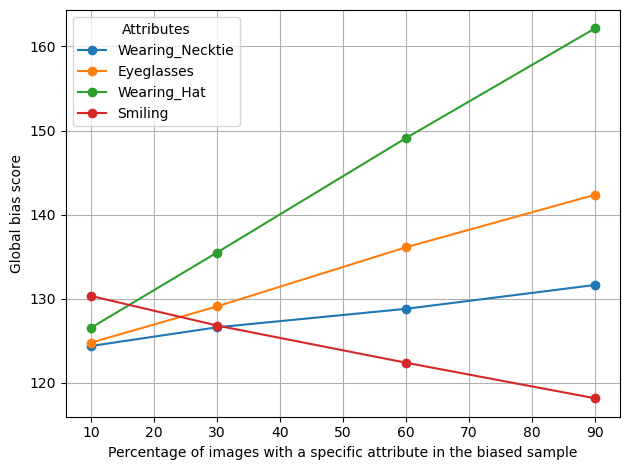

In [15]:
# plot the results
for  i, item in enumerate(global_bias.items()):
    
    attr, score_dict = item

    scores = [s for n, s in score_dict.items()]
    c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o", c=c)

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Global bias score")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/Kwegyir_global_plot_2.eps", format ="eps")
plt.show()

### Maximum Mean Discrepancy

In [16]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [1, 10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)

In [17]:
device = "mps"

MMD_val = dict()

space_unif = [torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach()\
         for file in unif_df["image_id"]]

for attr in attributes:
    MMD_val[attr] = dict()
    individual_bias[attr] = dict()
    
    for j in range(4):
        n = [10,30,60,90][j]
        
        space_biased = [torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach()\
                 for file in dataframes[attr][j]["image_id"]] 
        
        x = torch.cat(space_biased).reshape(len(space_biased), -1).to(device)
        y = torch.cat(space_unif).reshape(len(space_unif), -1).to(device)

        MMD_val[attr][n] = MMD(x, y, "rbf").to("cpu").detach().item()

In [18]:
MMD_val

{'Wearing_Necktie': {10: 0.0010608321754261851,
  30: 0.008415120653808117,
  60: 0.041189029812812805,
  90: 0.10046333074569702},
 'Eyeglasses': {10: 0.0010815785499289632,
  30: 0.0034935378935188055,
  60: 0.015738027170300484,
  90: 0.037460457533597946},
 'Wearing_Hat': {10: 0.001198061858303845,
  30: 0.006525024771690369,
  60: 0.026732956990599632,
  90: 0.062212616205215454},
 'Smiling': {10: 0.00358200934715569,
  30: 0.0014435838675126433,
  60: 0.0014965810114517808,
  90: 0.004759693518280983}}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


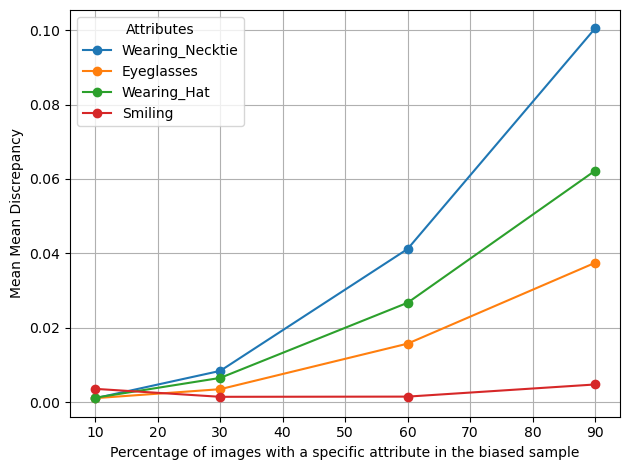

In [19]:
# plot the results
for  i, item in enumerate(MMD_val.items()):
    
    attr, score_dict = item

    scores = [s for n, s in score_dict.items()]
    c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o", c=c)

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Mean Mean Discrepancy")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/MMD_plot_2.eps", format ="eps")
plt.show()

## Biased MNIST

### Quadratic Wasserstein distance

In [20]:
# read results of the computation of Wasserstein distance stored in a .tsv
wasserstein_df_mnist = pd.read_csv("../results/experiment1/wasserstein_biased_mnist.tsv", sep= "\t", header=None)
wasserstein_df_mnist.columns = ["bias", "wasserstein"]

wasserstein_df_mnist

,bias,wasserstein
0,0.10,-2.991011
1,0.50,-0.969969
2,0.75,5.441967
3,0.90,15.485897
4,0.95,21.406267
5,0.99,27.803190


In [21]:
list(scores)

[0.00358200934715569,
 0.0014435838675126433,
 0.0014965810114517808,
 0.004759693518280983]

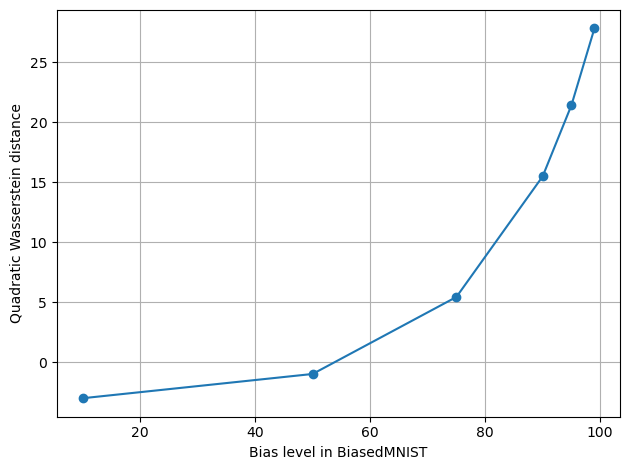

In [22]:
# plot of the results 
scores = wasserstein_df_mnist.wasserstein

plt.plot([10, 50, 75, 90, 95, 99], list(scores), "-o")

plt.title("")
plt.xlabel("Bias level in BiasedMNIST")
plt.ylabel("Quadratic Wasserstein distance")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/Wasserstein_distance_plot_mnist.eps", format="eps")
plt.show()

### SVM-baseline

In [23]:
# load embedded vectors for the test space
space_test = [torch.load("../data/biased_mnist/resnet18_features/full/test/" + str(i) + ".pt").detach().numpy()\
         for i in range(10000)]

#load train set indices
with open("../data/biased_mnist/train_ixs.json", "r") as file:
    indices = json.load(file)

scores = list()
distances_mnist = dict()
#decision_functions_mnist = dict()

for bias in ["0.1", "0.5", "0.75", "0.9", "0.95", "0.99"]:
    distances_mnist[bias] = list()
    space = [
        torch.load("../data/biased_mnist/resnet18_features/full_{}/trainval/{}.pt"
                   .format(bias, str(i))).detach().numpy()\
        for i in indices] + space_test
        
    X = np.concatenate(space)
    y = np.concatenate([np.ones(50000), np.zeros(10000)])
        
    # define the classifier
    classifier = svm.SVC(C=.01, kernel="linear", decision_function_shape="ovo")
        
    # train the classifier
    classifier.fit(X, y)
    scores.append( (.5*(classifier.decision_function(X)/np.linalg.norm(classifier.coef_))**2).mean() )
        
    distances_mnist[bias].append( classifier.decision_function(X[y == 1])/np.linalg.norm(classifier.coef_) )

KeyboardInterrupt: 

In [ ]:
# plot of the results 
plt.plot([10, 50, 75, 90, 95, 99], list(scores), "-o")

plt.title("")
plt.xlabel("Bias level in BiasedMNIST")
plt.ylabel("Quadratic distance from decision boundary")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/SVM_plot_mnist.eps", format="eps")
plt.show()

### Global bias

In [ ]:
# load embedded vectors for the test space
space_test = [torch.load("../data/biased_mnist/resnet18_features/full/test/" + str(i) + ".pt").detach().numpy()\
         for i in range(10000)]

global_bias_mnist = list()
individual_bias_mnist = dict()
    
for bias in ["0.1", "0.5", "0.75", "0.9", "0.95", "0.99"]:
        
    space_biased = [
        torch.load("../data/biased_mnist/resnet18_features/full_{}/trainval/{}.pt"
                   .format(bias, str(i))).detach().numpy()\
        for i in indices] 
        
    individual_bias_kwegyir = list()
    for s in space_biased:
        distances = list()
        for t in space_test:
            distances.append(.5*np.linalg.norm(s - t)**2)
        individual_bias_kwegyir.append(np.array(distances).mean())
    global_bias_kwegyir = np.array(individual_bias_kwegyir).mean()
        
    individual_bias_mnist[bias] = individual_bias_kwegyir
    global_bias_mnist.append(global_bias_kwegyir)

In [ ]:
# plot of the results 
plt.plot([10, 50, 75, 90, 95, 99], list(global_bias_mnist), "-o")

plt.title("")
plt.xlabel("Bias level in BiasedMNIST")
plt.ylabel("Global bias score")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/Global_Kwegyir_plot_mnist.eps", format="eps")
plt.show()

### Maximum Mean Discrepancy

In [ ]:
device = "mps"

MMD_val = list()
individual_bias = dict()

# load embedded vectors for the test space
space_test = [torch.load("../data/biased_mnist/resnet18_features/full/test/" + str(i) + ".pt").detach().numpy()\
         for i in range(10000)]

#load train set indices
with open("../data/biased_mnist/train_ixs.json", "r") as file:
    indices = json.load(file)

scores = list()
distances = dict()
decision_functions = dict()

for bias in ["0.1", "0.5", "0.75", "0.9", "0.95", "0.99"]:
    distances[bias] = list()
    space_biased = [
        torch.load("../data/biased_mnist/resnet18_features/full_{}/trainval/{}.pt"
                   .format(bias, str(i))).detach()\
        for i in indices]

        
    x = torch.cat(space_biased).reshape(len(space_biased), -1).to(device)
    y = torch.cat(space_unif).reshape(len(space_unif), -1).to(device)

    MMD_val.append(MMD(x, y, "rbf").to("cpu").detach().item())

In [ ]:
# plot of the results 
plt.plot([10, 50, 75, 90, 95, 99], list(MMD_val), "-o")

plt.title("")
plt.xlabel("Bias level in BiasedMNIST")
plt.ylabel("Maximum Mean Discrepancy")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/MMD_plot_mnist.eps", format="eps")
plt.show()

## Experiment 2

In [ ]:
def fun(string):
    if "resnet18_/" in string:
        return "Potential"
    else:
        return string

In [ ]:
sns.set_theme(style="ticks", palette="pastel")

for attr in attributes:
    for i in range(4):
        n = [10, 30, 60, 90][i]
        dataframes[attr][i].rename(mapper=fun, axis=1, inplace=True)
        dataframes[attr][i]["Percentage"] = "{}%".format(n)

    data = pd.concat(dataframes[attr])

    sns.boxplot(data=data,
                x="Percentage",
                y="Potential",
                hue=attr,
                palette=["m", "g"])
    
    sns.despine(offset=10, trim=True)
    
    plt.tight_layout()
    
    plt.savefig("../results/Experiment1/{0}_Boxplot_2.eps".format(attr, n), format="eps")
    
    plt.show()

In [ ]:
attributes_list = list()
perc = [10,30,60,90] * 4
stats = list()
p_val= list()

for attr in attributes:
    for i in range(4):
        df = dataframes[attr][i]
        col1 = df[df[attr] == 1].Potential
        col2 = df[df[attr] == -1].Potential
        
        test = ks_2samp(col1, col2, alternative = "greater")

        attributes_list.append(attr)
        stats.append(test.statistic)
        p_val.append(test.pvalue)

table = pd.DataFrame({"attribute" : attributes_list, "percentage" : perc, "statistic" : stats, "pvalue" : p_val})

In [ ]:
print(table.set_index(["attribute", "percentage"]).to_latex())

In [ ]:
decision_functions["Wearing_Hat"][30]

In [ ]:
for attr in attributes:
    to_concat = list()
    for i in range(4):
        n = [10, 30, 60, 90][i]
        to_concat.append({"Distance": decision_functions[attr][n]},
                        "Percentage": ["{}%".format(n)]*len(decision_functions[attr][n]))
        
    data = pd.concat(to_concat)

    sns.boxplot(data=data,
                x="Percentage",
                y="Distance",
                hue=attr,
                palette=["m", "g"])
    
    sns.despine(offset=10, trim=True)
    
    plt.tight_layout()
    
    plt.savefig("../results/Experiment1/{0}_kwegyir_Boxplot.eps".format(attr, n), format="eps")
    
    plt.show()

In [ ]:
attributes_list = list()
perc = [10,30,60,90] * 4
stats = list()
p_val= list()

for attr in attributes:
    for i in range(4):
        n = [10,30,60,90][i]
        df = decision_functions[attr][n]
        col1 = df[df[attr] == 1].Distance
        col2 = df[df[attr] == -1].Distance
        
        test = ks_2samp(col1, col2, alternative = "greater")

        attributes_list.append(attr)
        stats.append(test.statistic)
        p_val.append(test.pvalue)

table = pd.DataFrame({"attribute" : attributes_list, "Percentage" : perc, "statistic" : stats, "pvalue" : p_val})

In [ ]:
print(table.set_index(["attribute", "Percentage"]).to_latex())

In [ ]:
for attr in attributes:
    for i in range(4):
        n = [10, 30, 60, 90][i]
        individual_bias[attr][n]["Percentage"] = "{}%".format(n)

    data = pd.concat([d for n,d in decision_functions[attr].items()])

    sns.boxplot(data=data,
                x="Percentage",
                y="Distance",
                hue=attr,
                palette=["m", "g"])
    
    sns.despine(offset=10, trim=True)
    
    plt.tight_layout()
    
    plt.savefig("../results/Experiment1/{0}_distance_Boxplot.eps".format(attr, n), format="eps")
    
    plt.show()